In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

import random
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist

import wandb

In [2]:
def show(image, title):
    index = 1 
    plt.figure(figsize=(10,5))

    for x in zip(image, title):
        image = x[0]
        title = x[1]
        plt.subplot(2, 5, index)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.title(x[1], fontsize = 9)
        index += 1
    plt.show()

def load_MNIST(images_filepath, labels_filepath, verbose=False):
    # training_images_filepath = 'train-images.idx3-ubyte'
    # training_labels_filepath = 'train-labels.idx1-ubyte'
    # test_images_filepath = 't10k-images.idx3-ubyte'
    # test_labels_filepath = 't10k-labels.idx1-ubyte'

    X_images, y_labels = loadlocal_mnist( images_filepath, labels_filepath)

    if verbose:
        print('Dimension of images:', np.shape(X_images))
        print('Dimension of labels:',np.shape(y_labels))

    # reshape the arrays:
    X_images = X_images.reshape(-1, 28, 28)

    if verbose:
        print('Dimension of images:', np.shape(X_images))

    if verbose:
        image = []
        title = []

        for i in range(0, 5):
            r = random.randint(1, len(X_images))
            image.append(X_images[r])
            title.append('image:' + str(y_labels[r]))

        show(image, title)

    return X_images, y_labels

In [3]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 20

# random seed
random_seed = 0
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

wandb.init(project="Playground-MNIST CNN Classifier")
args = {
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "random_seed": random_seed
}
wandb.config.update(args)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kodogyu (kodogyu-kyung-hee-university). Use `wandb login --relogin` to force relogin


In [4]:
device = 'cuda'
print(device)

cuda


In [5]:
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform):
        self.images, self.labels = loadlocal_mnist(images_path, labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28,28)
        label = torch.tensor(self.labels[idx], dtype=int)

        if self.transform:
            image = self.transform(image)

        label = F.one_hot(label, 10).to(float)

        return image, label

transform = torchvision.transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNISTDataset("datasets/train-images.idx3-ubyte", "datasets/train-labels.idx1-ubyte", transform)
test_dataset = MNISTDataset("datasets/t10k-images.idx3-ubyte", "datasets/t10k-labels.idx1-ubyte", transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
print(len(train_dataset))
print(len(test_dataset))
print(len(train_dataloader))
print(len(test_dataloader))

60000
10000
1875
313


In [7]:
class myCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)  # (8,28,28)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)  # (16,14,14)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # (32,7,7)
        self.fc = nn.Linear(32, 10)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (B,8,28,28)
        x = F.relu(self.max_pool(self.conv2(x)))  # (B,16,14,14)
        x = F.relu(self.max_pool(self.conv3(x)))  # (B,32,7,7)
        x = F.avg_pool2d(x, kernel_size=7)  # (B,32,1,1)
        x = x.flatten(start_dim=1)  # (B,32)
        logit = self.fc(x)

        return logit

cnn = myCNN().to(device)
cnn.train()

myCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=32, out_features=10, bias=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [8]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

criterion = torch.nn.CrossEntropyLoss()

In [9]:
def get_test_acc(model):
    with torch.no_grad():
        # test
        correct_cnt = 0
        samples_cnt = 0
        for image, label in tqdm(test_dataloader):
            image = image.to(device)
            label = label.to(device)

            answer = torch.argmax(label, dim=1)

            pred = model(image)
            pred_label = torch.argmax(pred, dim=1)
            
            correct = (pred_label == answer)
            correct_cnt += correct.sum().item()
            samples_cnt += label.shape[0]

        acc = correct_cnt/samples_cnt
        print(f"{correct_cnt} / {samples_cnt}: {acc}")

    return acc

Epoch[0]


100%|██████████| 313/313 [00:00<00:00, 445.69it/s]


8740 / 10000: 0.874
Epoch[1]


100%|██████████| 313/313 [00:00<00:00, 334.37it/s]


9115 / 10000: 0.9115
Epoch[2]


100%|██████████| 313/313 [00:00<00:00, 346.25it/s]


9321 / 10000: 0.9321
Epoch[3]


100%|██████████| 313/313 [00:00<00:00, 332.25it/s]


9317 / 10000: 0.9317
Epoch[4]


100%|██████████| 313/313 [00:00<00:00, 382.04it/s]


9383 / 10000: 0.9383
Epoch[5]


100%|██████████| 313/313 [00:01<00:00, 279.94it/s]


9422 / 10000: 0.9422
Epoch[6]


100%|██████████| 313/313 [00:00<00:00, 337.19it/s]


9517 / 10000: 0.9517
Epoch[7]


100%|██████████| 313/313 [00:00<00:00, 372.27it/s]


9524 / 10000: 0.9524
Epoch[8]


100%|██████████| 313/313 [00:00<00:00, 320.11it/s]


9614 / 10000: 0.9614
Epoch[9]


100%|██████████| 313/313 [00:00<00:00, 348.94it/s]


9522 / 10000: 0.9522
Epoch[10]


100%|██████████| 313/313 [00:00<00:00, 458.69it/s]


9664 / 10000: 0.9664
Epoch[11]


100%|██████████| 313/313 [00:00<00:00, 347.51it/s]


9669 / 10000: 0.9669
Epoch[12]


100%|██████████| 313/313 [00:00<00:00, 345.71it/s]


9649 / 10000: 0.9649
Epoch[13]


100%|██████████| 313/313 [00:00<00:00, 327.87it/s]


9687 / 10000: 0.9687
Epoch[14]


100%|██████████| 313/313 [00:00<00:00, 355.54it/s]


9722 / 10000: 0.9722
Epoch[15]


100%|██████████| 313/313 [00:00<00:00, 313.09it/s]


9725 / 10000: 0.9725
Epoch[16]


100%|██████████| 313/313 [00:00<00:00, 317.38it/s]


9713 / 10000: 0.9713
Epoch[17]


100%|██████████| 313/313 [00:00<00:00, 326.01it/s]


9702 / 10000: 0.9702
Epoch[18]


100%|██████████| 313/313 [00:00<00:00, 339.65it/s]


9713 / 10000: 0.9713
Epoch[19]


100%|██████████| 313/313 [00:00<00:00, 342.67it/s]

9733 / 10000: 0.9733


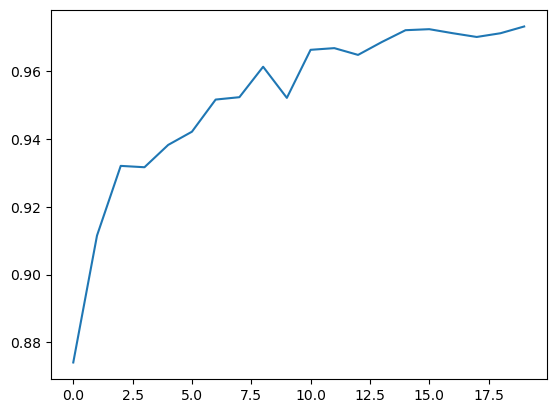

In [10]:
# train
test_acc_list = []

for epoch in range(num_epochs):
    print(f"Epoch[{epoch}]")
    correct_cnt = 0
    samples_cnt = 0

    tepoch = tqdm(train_dataloader)
    for idx, (image, label) in enumerate(tepoch):
        image = image.to(device)
        label = label.to(device)
        
        # forward
        optimizer.zero_grad()
        pred = cnn(image)

        # backward
        loss = criterion(pred, label)
        loss.backward()

        # update
        optimizer.step()

        # accuracy
        answer = torch.argmax(label, dim=1).detach().cpu().numpy()
        pred_label = torch.argmax(pred, dim=1).detach().cpu().numpy()
        correct_cnt += (answer == pred_label).sum()
        samples_cnt += label.shape[0]

        # logging
        tepoch.set_postfix({"loss": loss.item()})
        wandb.log({"Training loss": loss.item()})

    checkpoint = {
        "model_state_dict": cnn.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch
    }
    torch.save(checkpoint, f"ckpt_epoch{epoch}.pth")

    # train accuracy
    train_acc = correct_cnt / samples_cnt
    wandb.log({"Training accuracy": train_acc})

    # test accuracy
    test_acc = get_test_acc(cnn)
    test_acc_list.append(test_acc)
    wandb.log({"Test accuracy": test_acc})

plt.plot(test_acc_list)
plt.show()

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[9.9647121e-05 9.9139726e-01 3.1313190e-05 2.5433311e-10 5.3612473e-03
  1.0920079e-05 1.6413507e-05 1.8240778e-03 3.0975209e-06 1.2560583e-03]]
[[ -4.7738876    4.431348    -5.931483   -17.652388    -0.78857094
   -6.9849195   -6.5774183   -1.866693    -8.244921    -2.2397892 ]]
1


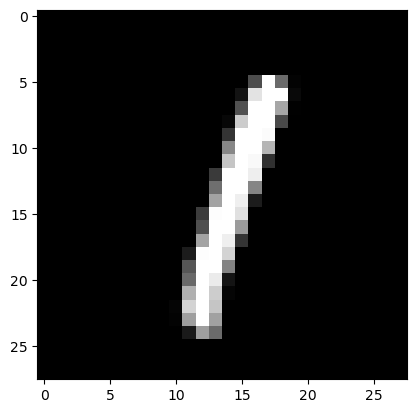

In [77]:
# test
idx = 5
it = iter(test_dataloader)
for _ in range(idx):
    next(it)

image, label = next(it)
image = image.to(device)
label = label.to(device)

pred = cnn(image)
pred_sm = F.softmax(pred, dim=1)

image = image.squeeze(0)
image_np = image.detach().permute(1,2,0).cpu().numpy()
plt.imshow(image_np, cmap='gray')
plt.show()

In [83]:
# test
correct_cnt = 0
samples_cnt = 0
for image, label in tqdm(test_dataloader):
    image = image.to(device)
    label = label.to(device)

    answer = torch.argmax(label)

    pred = cnn(image)
    pred_sm = F.softmax(pred, dim=1)

    pred_label = torch.argmax(pred_sm, dim=1)
    
    correct = (pred_label == answer)
    if correct:
        correct_cnt += 1
    samples_cnt += 1

print(f"{correct_cnt} / {samples_cnt}: {correct_cnt/samples_cnt}")

100%|██████████| 10000/10000 [00:08<00:00, 1215.01it/s]

9505 / 10000: 0.9505
